# Web scraping tutorial

Taken from: https://www.datacamp.com/community/tutorials/web-scraping-using-python

The dataset used in this tutorial was taken from a 10K race that took place in Hillsboro, OR on June 2017. Specifically, you will analyze the performance of the 10K runners and answer questions such as:

• What was the average finish time for the runners?

• Did the runners' finish times follow a normal distribution?

• Were there any performance differences between males and females of various age groups?

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
url = 'http://www.hubertiming.com/results/2017GPTR10K'
html = urlopen(url)

In [3]:
# Create a beautiful soup object from the html
soup = BeautifulSoup(html, 'lxml')
type(soup)

bs4.BeautifulSoup

In [4]:
# Bs4 object allows us to easily access properties
title = soup.title
print(title)

<title>2017 Intel Great Place to Run 10K \ Urban Clash Games Race Results</title>


In [5]:
# We can also strip html tags with .get_text() method
title.get_text()

'2017 Intel Great Place to Run 10K \\ Urban Clash Games Race Results'

In [6]:
soup.find_all('a')

[<a class="btn btn-primary btn-lg" href="/results/2017GPTR" role="button" style="margin: 0px 0px 5px 5px">5K</a>,
 <a href="https://www.hubertiming.com/">Huber Timing Home</a>,
 <a href="#individual">Individual Results</a>,
 <a href="#team">Team Results</a>,
 <a href="mailto:timing@hubertiming.com">timing@hubertiming.com</a>,
 <a href="#tabs-1" style="font-size: 18px">Results</a>,
 <a name="individual"></a>,
 <a name="team"></a>,
 <a href="https://www.hubertiming.com/"><img height="65" src="/sites/all/themes/hubertiming/images/clockWithFinishSign_small.png" width="50"/>Huber Timing</a>,
 <a href="https://facebook.com/hubertiming/"><img src="/results/FB-f-Logo__blue_50.png"/></a>]

To find just the hyperlinks from a given page, use a for loop on the `a` tags:

In [7]:
all_links = soup.find_all('a')

In [8]:
for link in all_links:
    print(link.get('href'))

/results/2017GPTR
https://www.hubertiming.com/
#individual
#team
mailto:timing@hubertiming.com
#tabs-1
None
None
https://www.hubertiming.com/
https://facebook.com/hubertiming/


In [11]:
# Make a list through a comprehension:
[link.get('href') for link in all_links]

['/results/2017GPTR',
 'https://www.hubertiming.com/',
 '#individual',
 '#team',
 'mailto:timing@hubertiming.com',
 '#tabs-1',
 None,
 None,
 'https://www.hubertiming.com/',
 'https://facebook.com/hubertiming/']

We're scraping a page with a table in it; so let's start by finding the rows:

In [12]:
rows = soup.find_all('tr')

In [14]:
print(rows[:5])

[<tr><td>Finishers:</td><td>577</td></tr>, <tr><td>Male:</td><td>414</td></tr>, <tr><td>Female:</td><td>163</td></tr>, <tr class="header">
<th>Place</th>
<th>Bib</th>
<th>Name</th>
<th>Gender</th>
<th>City</th>
<th>State</th>
<th>Chip Time</th>
<th>Chip Pace</th>
<th>Gender Place</th>
<th>Age Group</th>
<th>Age Group Place</th>
<th>Time to Start</th>
<th>Gun Time</th>
<th>Team</th>
</tr>, <tr>
<td>1</td>
<td>814</td>
<td>JARED WILSON</td>
<td>M</td>
<td>TIGARD</td>
<td>OR</td>
<td>00:36:21</td>
<td>05:51</td>
<td>1 of 414</td>
<td>M 36-45</td>
<td>1 of 152</td>
<td>00:00:03</td>
<td>00:36:24</td>
<td></td>
</tr>]


We want to take a table, and make it into a dataframe so we can work with it. To do this we need all data cells from all rows in a list first, and to get that list into a dataframe.

In [20]:
# Print just one row to make sure we're getting it
for row in rows:
    row_td = row.find_all('td')
print(row_td)
type(row_td)

[<td>14TH</td>, <td>INTEL TEAM M</td>, <td>04:43:23</td>, <td>00:58:59 - DANIELLE CASILLAS</td>, <td>01:02:06 - RAMYA MERUVA</td>, <td>01:17:06 - PALLAVI J SHINDE</td>, <td>01:25:11 - NALINI MURARI</td>]


bs4.element.ResultSet

We can see from the results that there are html tags embedded in each row. As we create the full list, we need to also strip html from the rows.

This is done by converting to string, then using BeautifulSoup's `get_text()` method on the string.

In [27]:
list_rows = []
for row in rows:
    row_td = row.find_all('td')
    # Clean embedded html tags
    str_cells = str(row_td)
    cleantext = BeautifulSoup(str_cells, "lxml").get_text()
    list_rows.append(cleantext)

In [29]:
# We now have each contender as a row,
# plus some extra row headers
list_rows[0:6]

['[Finishers:, 577]',
 '[Male:, 414]',
 '[Female:, 163]',
 '[]',
 '[1, 814, JARED WILSON, M, TIGARD, OR, 00:36:21, 05:51, 1 of 414, M 36-45, 1 of 152, 00:00:03, 00:36:24, ]',
 '[2, 573, NATHAN A SUSTERSIC, M, PORTLAND, OR, 00:36:42, 05:55, 2 of 414, M 26-35, 1 of 154, 00:00:03, 00:36:45, INTEL TEAM F]']

In [30]:
df = pd.DataFrame(list_rows)

In [31]:
df.head()

,0
0,"[Finishers:, 577]"
1,"[Male:, 414]"
2,"[Female:, 163]"
3,[]
4,"[1, 814, JARED WILSON, M, TIGARD, OR, 00:36:21..."


From this we can see that the '0' column needs to be split. Here's how it looks with just one cell.

In [38]:
df.iloc[4].str.split(',', expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,[1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]


In [39]:
df1 = df[0].str.split(',', expand=True)
df1.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,[Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,[Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,[Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,[],None,None,None,None,None,None,None,None,None,None,None,None,None
4,[1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,[2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,[3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,[4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,[5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]
9,[6,642,JONATHON TRAN,M,PORTLAND,OR,00:39:49,06:25,6 of 414,M 18-25,1 of 34,00:00:06,00:39:55,]


In [41]:
# Remove the opening square brackets in colum 0
df1[0] = df1[0].str.strip('[')
df1.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,],None,None,None,None,None,None,None,None,None,None,None,None,None
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]


The dataframe is missing headers. These are present in the original table as `th` tags,
so we can find them in the BeautifulSoup object.

In [42]:
col_labels = soup.find_all('th')

In [43]:
col_labels

[<th>Place</th>,
 <th>Bib</th>,
 <th>Name</th>,
 <th>Gender</th>,
 <th>City</th>,
 <th>State</th>,
 <th>Chip Time</th>,
 <th>Chip Pace</th>,
 <th>Gender Place</th>,
 <th>Age Group</th>,
 <th>Age Group Place</th>,
 <th>Time to Start</th>,
 <th>Gun Time</th>,
 <th>Team</th>]

In [47]:
# Strip tags again
col_headers = []
clean_headers = BeautifulSoup(str(col_labels), 'lxml').getText()
col_headers.append(clean_headers)

In [48]:
col_headers

['[Place, Bib, Name, Gender, City, State, Chip Time, Chip Pace, Gender Place, Age Group, Age Group Place, Time to Start, Gun Time, Team]']

We will now make the headers into a dataframe, and concatenate the two frames.

In [49]:
df_headers = pd.DataFrame(col_headers)
df_headers.head()

,0
0,"[Place, Bib, Name, Gender, City, State, Chip T..."


In [51]:
df_new_headers = df_headers[0].str.split(',', expand=True)

In [52]:
df_new_headers.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]


In [54]:
frames = [df_new_headers, df1]

df_both = pd.concat(frames)

In [56]:
df_both.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
0,Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,],None,None,None,None,None,None,None,None,None,None,None,None,None
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]


In [64]:
df_full = df_both.rename(columns=df_both.iloc[0])

In [65]:
df_full.head(1)

,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]


In [66]:
# Rename columns that still contain brackets
df_full.rename(columns={'[Place': 'Place', ' Team]': 'Team'},inplace=True)

In [67]:
df_full.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
0,Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,],None,None,None,None,None,None,None,None,None,None,None,None,None


In [70]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 595
Data columns (total 14 columns):
Place               597 non-null object
 Bib                596 non-null object
 Name               593 non-null object
 Gender             593 non-null object
 City               593 non-null object
 State              593 non-null object
 Chip Time          593 non-null object
 Chip Pace          578 non-null object
 Gender Place       578 non-null object
 Age Group          578 non-null object
 Age Group Place    578 non-null object
 Time to Start      578 non-null object
 Gun Time           578 non-null object
Team                578 non-null object
dtypes: object(14)
memory usage: 70.0+ KB


In [72]:
# The last records in the frame are actually from another frame
# with team records
df_full.tail(20)

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team
576,573,273,RACHEL L VANEY,F,OTHER,OR,01:38:17,15:51,160 of 163,F 18-25,21 of 21,00:00:17,01:38:34,]
577,574,467,ROHIT B DSOUZA,M,PORTLAND,OR,01:38:31,15:53,414 of 414,M 36-45,152 of 152,00:02:01,01:40:32,INTEL TEAM I]
578,575,471,CENITA D'SOUZA,F,PORTLAND,OR,01:38:32,15:53,161 of 163,F 46-55,22 of 22,00:02:02,01:40:34,]
579,576,338,PRANAVI APPANA,F,HILLSBORO,OR,01:40:47,16:15,162 of 163,F 26-35,59 of 59,00:01:14,01:42:01,]
580,577,443,LIBBY B MITCHELL,F,HILLSBORO,OR,01:41:18,16:20,163 of 163,F 36-45,56 of 56,00:00:52,01:42:10,]
581,Award,Name,Combined Time,1,2,3,4],None,None,None,None,None,None,None
582,1ST,DTNA2,02:54:41,00:40:36 - ANDY WEDAM,00:44:05 - VASILIOS TSIRIMIAGOS,00:44:48 - ANDRE RAUCH,00:45:10 - JONATHAN PARSONS],None,None,None,None,None,None,None
583,2ND,INTEL TEAM K,03:01:02,00:41:43 - WILLIAM BARRY,00:42:36 - EDDIE J FRIE,00:43:46 - SAMANTHA BAGLEY,00:52:55 - JOHN HAMILTON],None,None,None,None,None,None,None
584,3RD,INTEL TEAM F,03:06:06,00:36:42 - NATHAN A SUSTERSIC,00:39:21 - DEREK G OSBORNE,00:52:47 - CODY L COVEY,00:57:16 - VIRAJ P MODAK],None,None,None,None,None,None,None
585,4TH,DTNA1,03:15:33,00:40:28 - WITALI SPULING,00:46:45 - INGA ANDREYEVA,00:54:09 - KEATON WEISENBORN,00:54:10 - MAISIE WEISENBORN],None,None,None,None,None,None,None


In [80]:
df2 = df_full.dropna(axis=0, how='any')

In [81]:
# We can also see that the header row is duplicated as first row
df2.head(3)

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]


In [85]:
# So tell it to drop row 0
df3 = df2.drop(0)

In [86]:
df3.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]


We're nearly ready to work with the data. The last step is to remove all of the closing square brackets from the 'Team' column.

In [89]:
df3['Team'] = df3['Team'].str.strip(']')

## Analysis and visualization stage

What was the average finish time? To do that, we need to convert 'Chip Time' into just minutes.

We do this by making the column into a list in order to manipulate with a for loop.

In [91]:
time_list = df3[' Chip Time'].tolist()

In [92]:
time_mins = []
for time in time_list:
    h, m, s = time.split(':')
    mins = (int(h)*3600 + int(m)*60 + int(s))/60
    time_mins.append(mins)

In [94]:
time_mins[:5]

[36.35, 36.7, 37.733333333333334, 38.56666666666667, 39.35]

In [95]:
df3['Runner_mins'] = time_mins

In [96]:
# Describe the dataframe, only including number objects
df3.describe(include=[np.number])

,Runner_mins
count,577.000000
mean,60.035933
std,11.970623
min,36.350000
25%,51.000000
50%,59.016667
75%,67.266667
max,101.300000


In [104]:
# Set figsize once globally
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

([<matplotlib.axis.XTick at 0x7fa06a1cc9e8>],
 <a list of 1 Text xticklabel objects>)

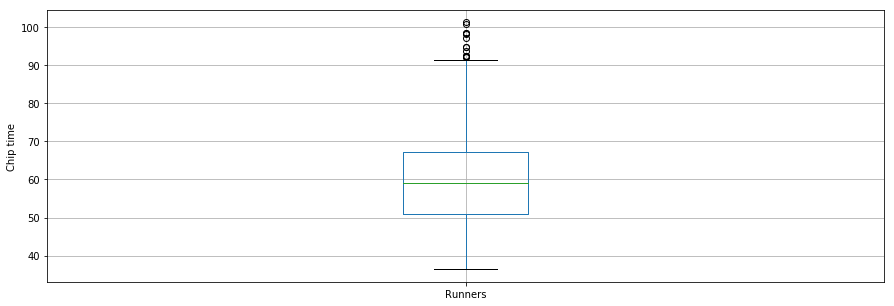

In [103]:
# Graph the distribution as a box plot 

df3.boxplot(column='Runner_mins')
plt.grid(True, axis='y')
plt.ylabel('Chip time')
plt.xticks([1], ['Runners'])

Now a useful thing to do is plot the times to see if they follow a normal distribution. We can do this with the Seaborn dist plot.

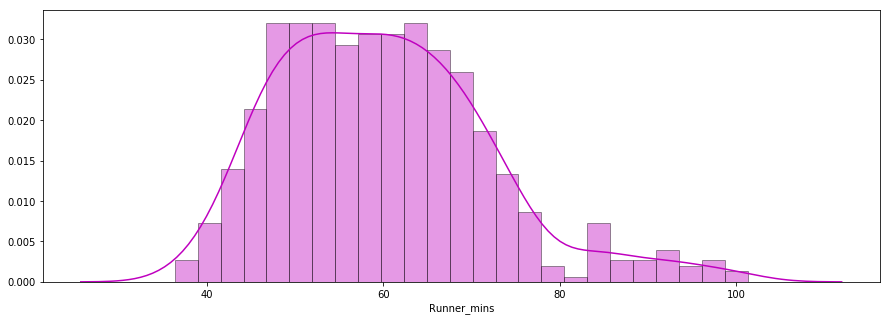

In [112]:
x = df3['Runner_mins']

ax = sns.distplot(x, hist=True, kde=True, rug=False, 
                  color='m', bins=25, hist_kws={'edgecolor':'black'})
plt.show()

In [110]:
type(x)

pandas.core.series.Series

In [116]:
f_times = df3[df3[' Gender']==' F']['Runner_mins']
m_times = df3[df3[' Gender']==' M']['Runner_mins']

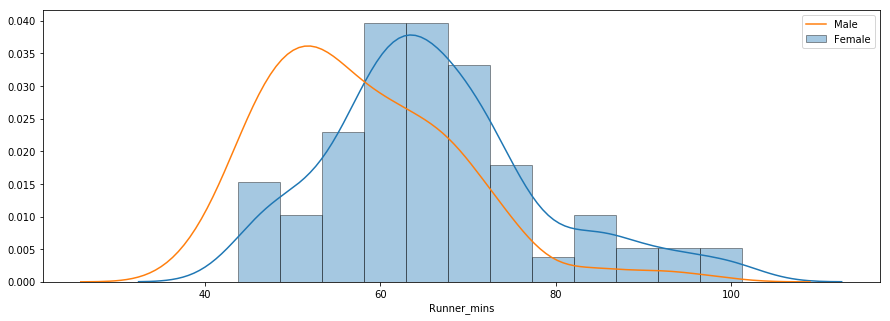

In [117]:
sns.distplot(f_times, hist=True, kde=True, rug=False, hist_kws={'edgecolor':'black'}, label='Female')
sns.distplot(m_times, hist=False, kde=True, rug=False, hist_kws={'edgecolor':'black'}, label='Male')
plt.legend()

In [125]:
# Group by gender then compute stats
df3.groupby(" Gender").describe()

Runner_mins                                                         \
              count       mean        std        min        25%        50%   
 Gender                                                                      
 F            163.0  66.119223  12.184440  43.766667  58.758333  64.616667   
 M            414.0  57.640821  11.011857  36.350000  49.395833  55.791667   

                                
               75%         max  
 Gender                         
 F       72.058333  101.300000  
 M       64.804167   98.516667

Text(0.5, 0.98, '')

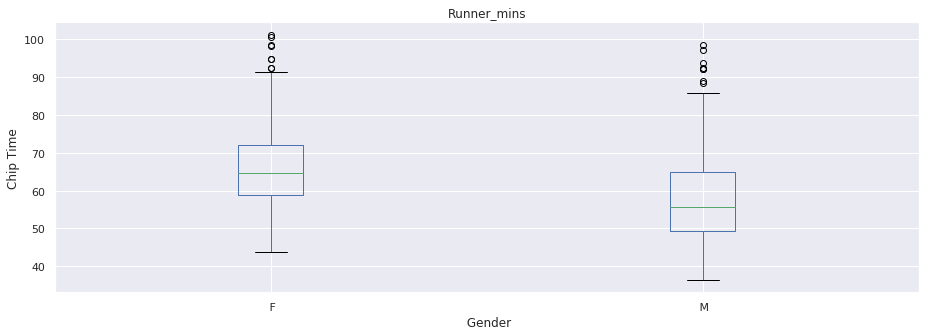

In [127]:
sns.set()

df3.boxplot(column='Runner_mins', by=' Gender')
plt.ylabel('Chip Time')
plt.suptitle("")